In [1]:
import numpy as np
from keras.datasets import cifar10
from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.engine.training import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,BatchNormalization,Activation,Conv2D,MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
model = Sequential()
import pandas as pd

In [2]:
def load_spam_data():
  dataset = pd.read_csv('communities.data',header=None);
  dataset.head()
  # rename the result column name
  dataset.rename(columns={127:'crimeRate'}, inplace=True)
  # checking missing values of county column
  counts = dataset[1].value_counts().to_dict()
  # print (counts)
  # adding a new county with code 100, which doesnt exist
  dataset[1] = dataset[1].replace('?','100')
  # we can delete the second column 
  # column 2 and 3 are same, 2 is the numeric representation of 3 so, we can convert it into numeric since 2 has alot of 
  # missing values
  dataset.drop(dataset.columns[[2]], axis=1,inplace=True)
  dataset[1] = dataset[1].astype(float)
  def GetColumnAvg(colnum):
      df = dataset[dataset[colnum] != '?']
      df[colnum] = df[colnum].astype(float)
      mean = df[colnum].mean()
      dataset[colnum] = dataset[colnum].replace('?',mean)
      dataset[colnum] = dataset[colnum].astype(float)
  # 30, 101 till 117, 121 to 124,126
  # we can see all this data is numeric and of nature that can be replaced by mean
  # for example
  # total requests for police 
  # police officers per 100K
  # percent of police (By race)
  # So, we replace them by avg of respective column
  for x in range(101, 118):
    GetColumnAvg(x)
  GetColumnAvg(121)
  GetColumnAvg(122)
  GetColumnAvg(123)
  GetColumnAvg(124)
  GetColumnAvg(126)
  GetColumnAvg(30)
  dataset[3] = labelencoder.fit_transform(dataset[3])
  x_train, x_test = train_test_split(dataset, train_size=0.6)
  y_train = x_train.pop('crimeRate')
  y_test = x_test.pop('crimeRate')
  return x_train,y_train,x_test,y_test


In [3]:
x_train,y_train,x_test,y_test = load_spam_data()
# normalize 
allFeatures = x_train;
allFeatures.append(x_test)
mean = allFeatures.mean(axis = 0)
std = allFeatures.std(axis=0)
x_train = x_train -mean
x_test = x_test-mean
x_train = x_train/std
x_test = x_test/std
print(x_train.shape)

(1196, 126)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
def GetCompiledModel():
  model = models.Sequential()
  model.add(layers.Dense(64,activation='relu',input_shape=(x_train.shape[1],)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(layers.Dense(64,activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
  return model

In [5]:
k = 7
Epochs = 300
FoldsScore = []
FoldsMAE = []
samplePerFold = len(x_train)//k
for i in range(k):
    print('Fold ',i)
    val_data = x_train[i * samplePerFold: (i+1) * samplePerFold]
    val_labels = y_train[i * samplePerFold: (i+1) * samplePerFold]
    train_data = np.concatenate([x_train[:i * samplePerFold],x_train[(i+1) * samplePerFold:]],axis = 0)
    train_labels = np.concatenate([y_train[:i*samplePerFold],y_train[(i+1)*samplePerFold:]],axis=0)
    model = GetCompiledModel()
    history = model.fit(train_data,train_labels,epochs=Epochs,batch_size=32,verbose=0)
    test_mse_score,test_mae_score = model.evaluate(val_data,val_labels)
    print(test_mae_score)
    mae_history = history.history['mae']
    FoldsMAE.append(mae_history)
    # record validation set performace per fold
    val_mse,val_mae = model.evaluate(val_data,val_labels,verbose=0)
    FoldsScore.append(val_mae)
average_mae_history = [np.mean([x[i] for x in FoldsMAE]) for i in range(Epochs)]

Fold  0
6/6 [==============================] - 0s 3ms/step - loss: 0.0239 - mae: 0.1049
0.10492009669542313
Fold  1
6/6 [==============================] - 0s 3ms/step - loss: 0.0294 - mae: 0.1138
0.1137658879160881
Fold  2
6/6 [==============================] - 0s 3ms/step - loss: 0.0170 - mae: 0.0886
0.08860623836517334
Fold  3
6/6 [==============================] - 0s 3ms/step - loss: 0.0205 - mae: 0.0993
0.09932903945446014
Fold  4
6/6 [==============================] - 0s 3ms/step - loss: 0.0232 - mae: 0.1037
0.10368524491786957
Fold  5
6/6 [==============================] - 0s 3ms/step - loss: 0.0244 - mae: 0.0995
0.0994618609547615
Fold  6
6/6 [==============================] - 0s 3ms/step - loss: 0.0319 - mae: 0.1145
0.11451437324285507


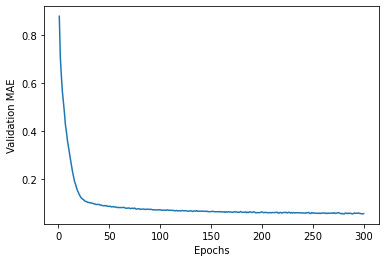

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
model = GetCompiledModel()
model.fit(x_train,y_train,epochs=40,batch_size=32)

Epoch 1/40
32/32 [==============================] - 1s 2ms/step - loss: 1.3406 - mae: 0.9030
Epoch 2/40
32/32 [==============================] - 0s 3ms/step - loss: 0.8167 - mae: 0.7091
Epoch 3/40
32/32 [==============================] - 0s 3ms/step - loss: 0.7129 - mae: 0.6623
Epoch 4/40
32/32 [==============================] - 0s 2ms/step - loss: 0.5617 - mae: 0.5779
Epoch 5/40
32/32 [==============================] - 0s 2ms/step - loss: 0.4429 - mae: 0.5165
Epoch 6/40
32/32 [==============================] - 0s 2ms/step - loss: 0.3598 - mae: 0.4773
Epoch 7/40
32/32 [==============================] - 0s 3ms/step - loss: 0.3102 - mae: 0.4268
Epoch 8/40
32/32 [==============================] - 0s 2ms/step - loss: 0.2522 - mae: 0.3854
Epoch 9/40
32/32 [==============================] - 0s 2ms/step - loss: 0.2171 - mae: 0.3601
Epoch 10/40
32/32 [==============================] - 0s 2ms/step - loss: 0.1877 - mae: 0.3329
Epoch 11/40
32/32 [==============================] - 0s 2ms/step - lo

In [ ]:
test_mse_score,test_mae_score = model.evaluate(x_test,y_test)
print (test_mse_score)
print(test_mae_score)
model.save("model3.hdf5")

25/25 [==============================] - 0s 2ms/step - loss: 0.0192 - mae: 0.0972
0.019162675365805626
0.09717722982168198
